## Visualize Diagnostics

Dropdown(description='Diagnostics File:', index=45, layout=Layout(width='max-content'), options=('c:\\Users\\a…

IntSlider(value=5, continuous_update=False, description='SMA Window Size:', layout=Layout(width='max-content')…

Button(description='Save Plot', icon='save', style=ButtonStyle(), tooltip='Click to save the current plot')

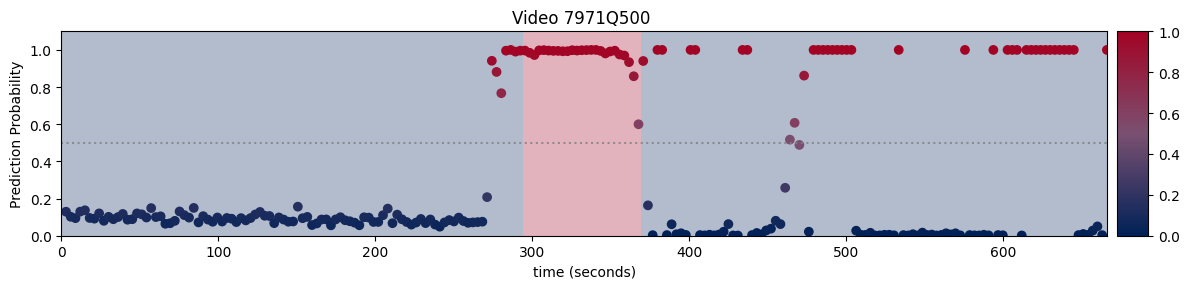

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import ast
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable


def parse_predictions(preds_str):
    preds = []
    preds_str = preds_str.strip()[1:-1]  # Remove the outer brackets
    preds_list = preds_str.split('array(')
    for pred in preds_list[1:]:
        pred_values = re.findall(r"[-+]?\d*\.\d+|\d+", pred.split(']')[0])
        preds.append(min(float(pred_values[1]), 1.0))  # Take the second value for the positive class probability
    return preds

def simple_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Flips the false positive and false negative entries, these are calculated correctly for 
# the metrics but the display CM function is opossite.
def flip_matrix_entries(matrix):
    if len(matrix) != 2 or len(matrix[0]) != 2 or len(matrix[1]) != 2:
        raise ValueError("Input must be a 2x2 matrix")
    
    matrix[0][1], matrix[1][0] = matrix[1][0], matrix[0][1]
    
    return matrix

def plot_predictions_and_labels(diagnostics_path, non_seizure_color:str="#bacfec", seizure_color:str="#ce8080", title="", ax=None):

    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()
    
    # Extract labels and preds
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))

    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))

    time_intervals = np.linspace(0, len(labels), len(labels))

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    else:
        fig = ax.figure
    
    # Create color map for labels and plot
    pred_cmap = LinearSegmentedColormap.from_list("pred_colormap", [non_seizure_color, "#7a5071", seizure_color])
    colors = [non_seizure_color, seizure_color]
    cmap = ListedColormap(colors)
    ax.hlines(y=[0.5], xmin=time_intervals[0], xmax=3*time_intervals[-1], linestyles='dotted', colors='grey', alpha=0.8)
    ax.imshow([labels], cmap=cmap, aspect='auto', extent=[time_intervals[0], 3*np.array(time_intervals[-1]), 0, 1.1], alpha=0.3)

    # Plot predictions as scatter plot
    scatter = ax.scatter(3*np.array(time_intervals[1:]), preds, label='Predictions', c=preds, cmap=pred_cmap, vmin=0, vmax=1, alpha=1)
    ax.set_ylabel('Prediction Probability')
    ax.set_xlabel('time (seconds)')
    ax.set_ylim(0, 1.1)
    ax.set_title(title)

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(scatter, cax=cax)

    plt.tight_layout()
    plt.show()
    return fig

def plot_diagnostics(diagnostics_path, sma_window_size=5, title=""):
    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()
    
    # Extract confusion matrix
    confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
    confusion_matrix_match = confusion_matrix_pattern.search(content)
    if confusion_matrix_match:
        cm = np.array([
            list(map(int, confusion_matrix_match.group(1).split())),
            list(map(int, confusion_matrix_match.group(2).split()))
        ])
        cm = flip_matrix_entries(cm)
    
    # Extract labels
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))
        labels2 = np.array(labels) + 1.1

    print(labels)
    print(f"Number Labels: {len(labels)}")

    # Extract predictions
    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))
        preds2 = np.array(preds) + 1.1

    print(preds)
    print(f"Number Preds: {len(preds)}")

    # Extract images saved for ROC and PC curves
    roc_pr_pattern = re.compile(r'Combined ROC and Precision-Recall Curves saved at: (.*)')
    roc_pr_match = roc_pr_pattern.search(content)
    roc_pr_image_path = None
    if roc_pr_match:
        roc_pr_image_path = roc_pr_match.group(1).strip()
    
    # Calculate the time intervals based on the length of the video
    time_intervals = np.linspace(0, len(labels), len(labels))

    # Calculate the simple moving average of the predictions
    sma_preds = simple_moving_average(preds, sma_window_size)
    sma_preds2 = np.array(sma_preds) + 1.1

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    gs = axs[0, 0].get_gridspec()
    # Remove the underlying axes
    for ax in axs[0, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[0, :])

    # Plot labels and predictions over time
    axbig.plot(time_intervals, labels, label='Labels', color='blue')
    axbig.scatter(time_intervals[1:], preds, label='Predictions', color='red', alpha=0.3)
    axbig.plot(time_intervals, labels2, color='blue')
    axbig.plot(time_intervals[sma_window_size:], sma_preds2, label=f'SMA Predictions (window={sma_window_size})', color='green', alpha=0.5)
    axbig.set_xlabel('Clip')
    axbig.set_ylabel('Class')
    axbig.set_ylim(0,2.2)
    axbig.set_title(title + 'Labels and Predictions over Time')
    axbig.hlines([0.5,1.6],[0,0],[max(time_intervals),max(time_intervals)], colors=['grey','grey'],linestyles=['dashed','dashed'] )
    axbig.legend()

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues', values_format='d', ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')

    # Plot ROC and Precision-Recall Curves image
    if roc_pr_image_path and os.path.exists(roc_pr_image_path):
        roc_pr_image = plt.imread(roc_pr_image_path)
        axs[1, 1].imshow(roc_pr_image)
        axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

Videos_key = ['00105B00', '00105C00', '00108500', '00108700', '00200100', '00200200', '22200Q01', '22200S00', '22200T00', '77952GP00', '7913ZY00', '7940HO00', '7940HU00', '7940K700', '79410R00', '7941CO00', '7941D100', '7941D200', '7941D300', '7941D400', '7941D500', '7941D600', '7941E901', '7941EA00', '7941EC00', '7941LY00', '7941M700', '7942GT00', '7942GU00', '7942GZ00', '7942QQ00', '7942QR00', '79519000', '7951EX00', '7952DG00', '7952DP00', '7953A100', '7953A400', '7962TA00', '7964JU00', '7970IA00', '79719R00', '7971C500', '7971C700', '7971H000', '7971Q500', '7971UI00', '7972M300', '7972OT00']

def get_files(dir):
    files = []
    for d,r,f in os.walk(dir):
        for file in f:
            files.append(os.path.join(d,file))
    return files

current_dir = os.path.join(os.getcwd(), 'Test_LOPO/LOPO_TEST_allvids')
current_options = get_files(current_dir)
# Create widgets for diagnostics file selection and SMA window size
# Create widgets for diagnostics file selection and SMA window size
diagnostics_file_widget = widgets.Dropdown(
    options=current_options,
    description='Diagnostics File:',
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

sma_window_size_widget = widgets.IntSlider(
    value=5, min=1, max=20, step=1,
    description='SMA Window Size:',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

s_color = "#a30324"
ns_color = "#002157"

# Create a save button
save_button = widgets.Button(
    description='Save Plot',
    disabled=False,
    button_style='',
    tooltip='Click to save the current plot',
    icon='save'
)

current_figure = None

def update_plot(change=None):
    global current_figure
    clear_output(wait=True)
    display(diagnostics_file_widget, sma_window_size_widget, save_button)
    title = f"Video {Videos_key[diagnostics_file_widget.index]} "
    current_figure = plot_predictions_and_labels(diagnostics_file_widget.value, title=title, non_seizure_color=ns_color, seizure_color=s_color)

def save_plot(b):
    global current_figure
    if current_figure is not None:
        # Create 'good_images' directory if it doesn't exist
        os.makedirs('good_images', exist_ok=True)
        
        # Generate filename based on the current video key
        filename = f"good_images/plot_{Videos_key[diagnostics_file_widget.index]}.png"
        
        # Save the figure
        current_figure.savefig(filename, dpi=800, bbox_inches='tight')
        print(f"Plot saved as {filename}")
    else:
        print("No plot to save. Please generate a plot first.")

# Observe changes in the widgets
diagnostics_file_widget.observe(update_plot, names='value')
sma_window_size_widget.observe(update_plot, names='value')
save_button.on_click(save_plot)

# Initial display of widgets
display(diagnostics_file_widget, sma_window_size_widget, save_button)
update_plot()

### Calculate summary statistics

In [7]:
def calculate_metrics_from_folder(folder_path):
    # Dictionary to store all extracted values
    all_values = {
        'Cross-entropy loss': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': [],
        'AUC': [],
        'Specificity': []
    }
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                content = file.read()
                
                confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
                confusion_matrix_match = confusion_matrix_pattern.search(content)
                if confusion_matrix_match:
                    cm = np.array([
                        list(map(int, confusion_matrix_match.group(1).split())),
                        list(map(int, confusion_matrix_match.group(2).split()))
                    ])
                    specificity = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
                    all_values['Specificity'].append(specificity)
                
                # Extract other metrics
                for metric in all_values.keys():
                    if metric != 'Specificity':
                        match = re.search(f"{metric}:\\s*(\\d+\\.\\d+)", content)
                        if match:
                            all_values[metric].append(float(match.group(1)))
    
    # Calculate statistics for each metric
    results = {}
    for metric, values in all_values.items():
        if values:
            results[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
        else:
            results[metric] = {
                'mean': None,
                'std': None,
                'min': None,
                'max': None
            }
    
    return results

def print_metrics_nicely(results):
    print("Metrics Summary:")
    print("----------------")
    for metric, stats in results.items():
        if stats['mean'] is not None:
            formatted_result = f"{metric}: μ = {stats['mean']:.3f} ± {stats['std']:.3f}; Range: {stats['min']:.3f}-{stats['max']:.3f}"
        else:
            formatted_result = f"{metric}: No data available"
        print(formatted_result)

def graph_bars_allvideos(results_folder):
    # Dictionary to store all extracted values
    all_values = {
        'Cross-entropy loss': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': [],
        'AUC': [],
        'Specificity': []
    }
    
    # Iterate through all files in the folder
    for filename in os.listdir(results_folder):
        if filename.endswith('.txt'):
            file_path = os.path.join(results_folder, filename)
            with open(file_path, 'r') as file:
                content = file.read()
                
                # Extract confusion matrix
                confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
                confusion_matrix_match = confusion_matrix_pattern.search(content)
                if confusion_matrix_match:
                    cm = np.array([
                        list(map(int, confusion_matrix_match.group(1).split())),
                        list(map(int, confusion_matrix_match.group(2).split()))
                    ])
                    specificity = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
                    all_values['Specificity'].append(specificity)
                
                # Extract other metrics
                for metric in all_values.keys():
                    if metric != 'Specificity':
                        match = re.search(f"{metric}:\\s*(\\d+\\.\\d+)", content)
                        if match:
                            all_values[metric].append(float(match.group(1)))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 9))
    axes = [ax1, ax2, ax3, ax4]
    colors = ['#00545e', '#7a5071', '#a30234', '#e37c1d']
    data = [np.array(all_values['Accuracy'])*100, all_values['AUC'], all_values['Recall'], all_values['Specificity']]
    metrics = ['Accuracy', 'AUC', 'Recall', 'Specificity']
    metric_unit = [" (%)", " Score", "", ""]
    x = Videos_key  # Assuming all metrics have the same number of values

    for i, (ax, y, color, metric) in enumerate(zip(axes, data, colors, metrics)):
        bars = ax.bar(x, y, color=color, alpha = 0.8)
        if i != 3: ax.set_xticks([])
        else: ax.set_xticklabels(x, rotation=-60, ha='left')
        if i == 0: ax.set_ylim(0,100)
        else: ax.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
        if i == 3: ax.set_xlabel('Video ID')
        ax.set_ylabel(metric + metric_unit[i])
        ax.spines[['right', 'top']].set_visible(False)
    # Set title for the entire figure
    fig.suptitle('Model Performance by Video', fontsize=16)
    fig.set_dpi(800)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [8]:
print_metrics_nicely(calculate_metrics_from_folder("TEST_LOPO/LOPO_TEST_allvids"))
# recall = sensitivity, precision =/= specificity

Metrics Summary:
----------------
Cross-entropy loss: μ = 0.171 ± 0.150; Range: 0.018-0.611
Precision: μ = 0.687 ± 0.208; Range: 0.172-1.000
Recall: μ = 0.969 ± 0.056; Range: 0.750-1.000
F1 Score: μ = 0.782 ± 0.157; Range: 0.294-1.000
Accuracy: μ = 0.938 ± 0.068; Range: 0.694-1.000
AUC: μ = 0.990 ± 0.016; Range: 0.901-1.000
Specificity: μ = 0.933 ± 0.080; Range: 0.622-1.000


In [9]:
graph_bars_allvideos("TEST_LOPO/LOPO_TEST_allvids")

C:\Users\aidan\AppData\Local\Temp\ipykernel_7216\2463528352.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  else: ax.set_xticklabels(x, rotation=-60, ha='left')


### Calculate detection latency

In [21]:
def get_preds_labels(diagnostics_path):
    with open(diagnostics_path, 'r') as file:
        content = file.read()
    
    # Extract labels and preds
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))

    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))
    
    return preds, labels

Average detection latency: 0.61s ± 2.01s
Median detection latency: 0.00. IQR: [0. 0.]


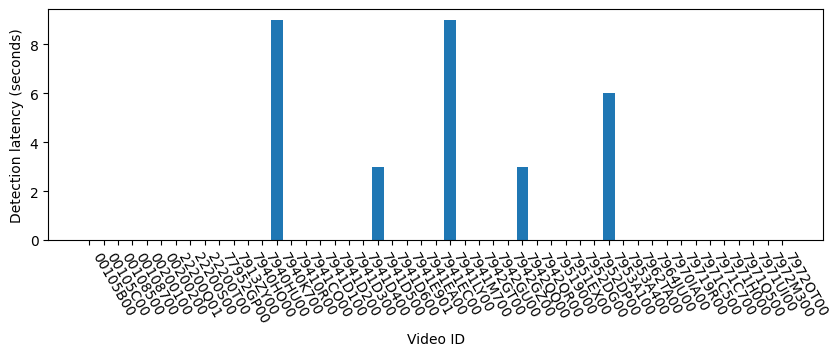

In [49]:
def detection_latency(predictions, labels):
    predictions = np.array(np.round(predictions))
    labels = np.array(labels[:-1])
    
    # Find the start of each anomaly in the labels
    anomaly_starts = np.where((labels[:-1] == 0) & (labels[1:] == 1))[0] + 1
    
    latencies = []
    for start in anomaly_starts:
        # Find the first prediction of 1 after the anomaly starts
        detection_index = np.argmax(predictions[start:] > 0.5) + start
        
        # If no detection is made, set latency to infinity
        if predictions[detection_index] <= 0.5:
            latencies.append(float('inf'))
        else:
            latencies.append(detection_index - start)

    latencies = np.array(latencies[0])*3
    return latencies

dts = []
for root, dirs, files in os.walk("Test_LOPO/LOPO_TEST_allvids"):
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            preds, labels = get_preds_labels(file_path)
            dts.append(detection_latency(preds, labels))
print(f"Average detection latency: {np.mean(dts):.2f}s ± {np.std(dts):.2f}s")
print(f"Median detection latency: {np.median(dts):.2f}. IQR: {np.percentile(dts, [25,75])}")
plt.figure(figsize=(10,3))
plt.bar(Videos_key, dts)
plt.xticks(rotation=-60, ha='left')
plt.ylabel("Detection latency (seconds)")
plt.xlabel("Video ID")
plt.show()


### Generate all GradCam videos

In [ ]:
import re

def parse_patient_info(file_path):
    patients = {}
    current_patient = None
    
    with open(file_path, 'r') as file:
        for line in file:
            # Check if the line is a patient header
            header_match = re.match(r'Patient (\d+) \((\d+)\):', line)
            if header_match:
                patient_number = header_match.group(1)
                patient_id = header_match.group(2)
                current_patient = {
                    'ID': patient_id,
                    'Videos': []
                }
                patients[patient_number] = current_patient
            # Check if the line is a video entry
            elif current_patient:
                video_match = re.match(r'\(\'Videos\/(.+?)\.mp4\', \d+, \d+, \'(.+?)\', sec\)', line)
                if video_match:
                    video_id = video_match.group(2)
                    current_patient['Videos'].append(video_id)
    
    return patients

file_path = 'annotations/usuable_data.txt'
patients = parse_patient_info(file_path)

{'1': {'ID': '06348578', 'Videos': ['7942GT00', '7942GU00', '7942GZ00']}, '2': {'ID': '05501184', 'Videos': ['7913ZY00']}, '3': {'ID': '05418761', 'Videos': ['7972M300']}, '4': {'ID': '06394294', 'Videos': ['7942QQ00', '7942QR00', '00200200']}, '5': {'ID': '05467817', 'Videos': ['7971Q500']}, '6': {'ID': '05323733', 'Videos': ['7971UI00']}, '7': {'ID': '05486196', 'Videos': ['7941M700']}, '8': {'ID': '05514820', 'Videos': ['7941LY00']}, '9': {'ID': '05513119', 'Videos': ['00200100']}, '10': {'ID': '02267738', 'Videos': ['7941EC00']}, '11': {'ID': '05447543', 'Videos': ['7941D100', '7941D200', '7941D300', '7941D400', '7941D500', '7941D600']}, '12': {'ID': '02268547', 'Videos': ['7940K700']}, '13': {'ID': '05454991', 'Videos': ['79410R00']}, '14': {'ID': '05497695', 'Videos': ['7941E901', '7941EA00', '7971C500', '7971C700']}, '15': {'ID': '05463487', 'Videos': ['79519000']}, '16': {'ID': '05235825', 'Videos': ['79719R00']}, '17': {'ID': '05352576', 'Videos': ['7970IA00', '7940HO00', '794

In [ ]:
import os
import subprocess

def generate_gradcam_commands(input_dict):
    commands = []
    
    for entry in input_dict.values():
        id = entry['ID']
        videos = entry['Videos']
        
        # Find the best_top1_acc file
        checkpoint_dir = f"checkpoints/train_all/{id}/"
        best_checkpoint = next((file for file in os.listdir(checkpoint_dir) if file.startswith("best_top1_acc")), None)
        
        if best_checkpoint:
            for video in videos:
                command = (
                    f"python tools/aidan_gradcam.py i3d_gaussian/i3d_config_{id}.py "
                    f"checkpoints/train_all/{id}/{best_checkpoint} "
                    f"videos/{video}.mp4 --target-layer-name backbone/layer4/1/relu "
                    f"--out-filename Video_GradCam/{video}_GradCam.mp4"
                )
                commands.append(command)
    
    return commands

def run_commands(commands):
    for i, command in enumerate(commands, 1):
        print(f"Running command {i} of {len(commands)}:")
        print(command)
        try:
            subprocess.run(command, shell=True, check=True)
            print(f"Command {i} completed successfully.\n")
        except subprocess.CalledProcessError as e:
            print(f"Command {i} failed with error: {e}\n")

commands = generate_gradcam_commands(patients)
run_commands(commands)

Running command 1 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_06348578.py checkpoints/train_all/06348578/best_top1_acc_epoch_1.pth videos/7942GT00.mp4 --target-layer-name backbone/layer4/1/relu --out-filename Video_GradCam/7942GT00_GradCam.mp4
Command 1 completed successfully.

Running command 2 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_06348578.py checkpoints/train_all/06348578/best_top1_acc_epoch_1.pth videos/7942GU00.mp4 --target-layer-name backbone/layer4/1/relu --out-filename Video_GradCam/7942GU00_GradCam.mp4
Command 2 completed successfully.

Running command 3 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_06348578.py checkpoints/train_all/06348578/best_top1_acc_epoch_1.pth videos/7942GZ00.mp4 --target-layer-name backbone/layer4/1/relu --out-filename Video_GradCam/7942GZ00_GradCam.mp4
Command 3 completed successfully.

Running command 4 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_05501184.py checkpoints/train_all

### Combined ROC plots

In [10]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import ast

def extract_data_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        
        labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
        labels_match = labels_pattern.search(content)
        if labels_match:
            labels = ast.literal_eval(labels_match.group(1))

        preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
        preds_match = preds_pattern.search(content)
        if preds_match:
            preds = parse_predictions(preds_match.group(1))
    
    return labels[1:], preds

def plot_auc_roc_curve(directory):
    plt.figure()
    
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_path.endswith("txt"):
            labels, preds = extract_data_from_file(file_path)
        
        if labels is None or preds is None:
            continue
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC by video (uncropped)')
    plt.show()


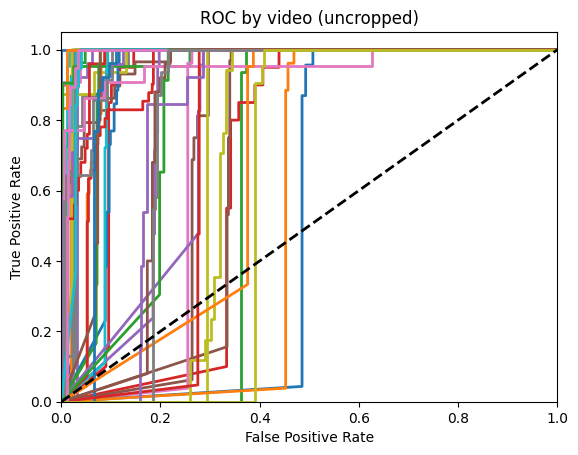

In [12]:
# Example usage
directory = os.path.join(os.getcwd(), "TEST_LOPO/LOPO_TEST_allvids")
plot_auc_roc_curve(directory)

### Plot all time series

In [13]:
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr

s_color = "#a30324"
ns_color = "#002157"
m_color = "#7a5071"

def plot_predictions_and_labels_ax(diagnostics_path, non_seizure_color:str=ns_color, seizure_color:str=s_color, middle_color:str=m_color, title="", ax=None, cm_only:bool=False):
    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()

    # Extract confusion matrix
    confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
    confusion_matrix_match = confusion_matrix_pattern.search(content)
    if confusion_matrix_match:
        cm = np.array([
            list(map(int, confusion_matrix_match.group(1).split())),
            list(map(int, confusion_matrix_match.group(2).split()))
        ])
        cm = flip_matrix_entries(cm)
        acc = (100*(cm[0,0]+cm[1,1])/(sum(sum(cm))))

    if cm_only: return cm, _

    sma_window_size = 5
    # Extract labels and preds
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))

    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))
        sma_preds = simple_moving_average(preds, sma_window_size)


    time_intervals = np.linspace(0, len(labels), len(labels))
    video_length = 3*(len(labels))

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))  # Changed height to 4 to maintain 3:1 ratio
    
    # Create color map for labels and plot
    pred_cmap = LinearSegmentedColormap.from_list("pred_colormap", [non_seizure_color, middle_color, seizure_color])
    colors = [non_seizure_color, seizure_color]
    cmap = ListedColormap(colors)
    ax.imshow([labels], cmap=cmap, aspect='auto', extent=[time_intervals[0], 3*np.array(time_intervals[-1]), 0, 1.1], alpha=0.3)

    # Plot predictions as scatter plot
    ax.hlines(y=0.5, xmin=time_intervals[0], xmax=3*np.array(time_intervals[-1]), linestyles='dashed',colors='grey')
    ax.plot(3*np.array(time_intervals[sma_window_size:]), sma_preds, alpha=0.5)
    ax.scatter(3*np.array(time_intervals[1:]), preds, label='Predictions', c=preds, cmap=pred_cmap, vmin=0, vmax=1, alpha=1)
    ax.set_ylabel('Prediction Probability')
    ax.set_xlabel('time (seconds)')
    ax.set_ylim(0, 1.1)
    ax.set_title(title)
    #ax.legend()
    return(cm, video_length)

def plot_all_txt_files(directory_path):
    # Get all .txt files in the directory
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    if not txt_files:
        print("No .txt files found in the directory.")
        return

    # Calculate the grid dimensions
    n_files = len(txt_files)
    n_cols = min(8, n_files * 2)  # Max 6 columns (doubled from 3)
    n_rows = (n_files - 1) // (n_cols // 2) + 1

    # Create a figure with subplots
    fig = plt.figure(figsize=(25, 2 * n_rows))  # Doubled width from 15 to 30
    gs = GridSpec(n_rows, n_cols, figure=fig, height_ratios=[1]*n_rows, width_ratios=[1]*n_cols)
    accs = []
    video_lengths = []
    
    for i, txt_file in enumerate(txt_files):
        row = i // (n_cols // 2)
        col = (i % (n_cols // 2)) * 2
        
        # Create a subplot spanning two columns
        ax = fig.add_subplot(gs[row, col:col+2])
        title = f"Video {Videos_key[i]} "
        
        # Plot the predictions and labels
        file_path = os.path.join(directory_path, txt_file)
        cm, video_length = plot_predictions_and_labels_ax(file_path, title=title, ax=ax)
        acc = (100*(cm[0,0]+cm[1,1])/(sum(sum(cm))))
        accs.append(acc)
        video_lengths.append(video_length)

    print(f"Mean Accuracy: {(np.mean(accs)):.2f}%")
    print(f"Median Accuracy: {(np.median(accs)):.2f}%")

    correlation_coefficient, p_value = pearsonr(accs, video_lengths)
    print(f"Correlation coefficient between accuracy and video length: {correlation_coefficient:.4f}")
    print(f"P-value: {p_value:.4f}")

    plt.tight_layout()
    plt.show()

    return(accs, video_lengths)

Mean Accuracy: 93.82%
Median Accuracy: 96.75%
Correlation coefficient between accuracy and video length: 0.1732
P-value: 0.2339


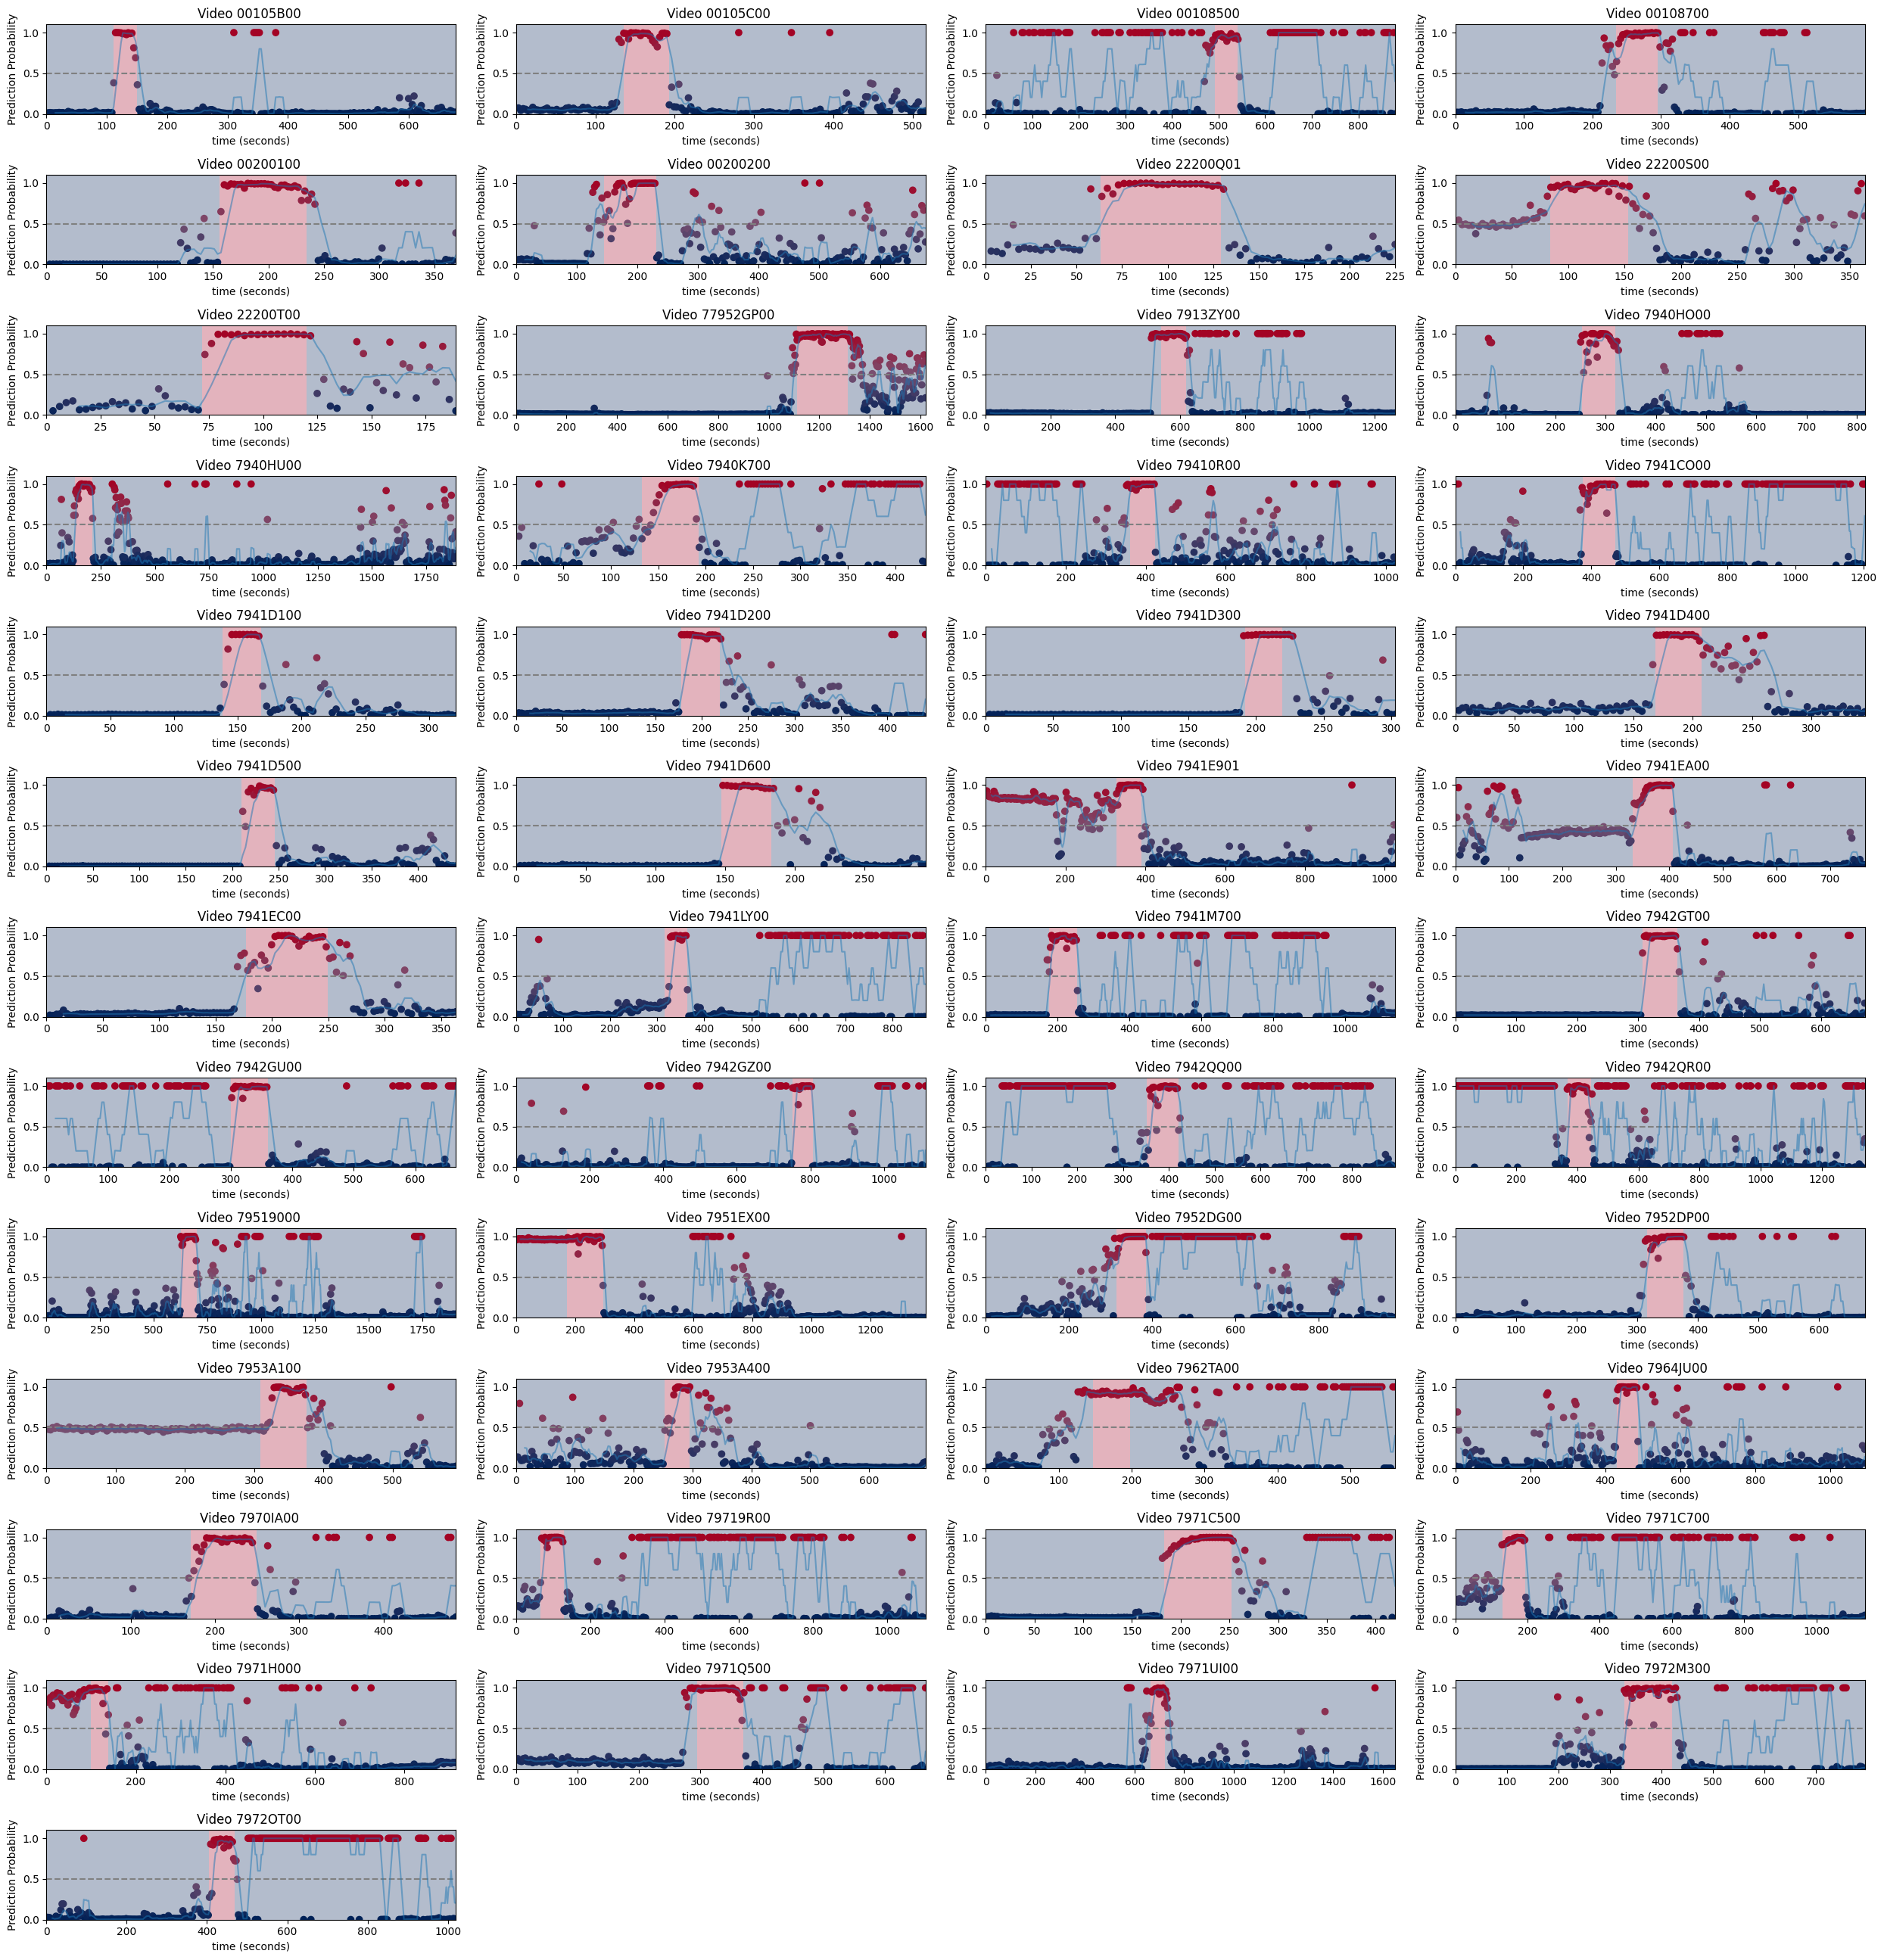

In [14]:
ac,vl = plot_all_txt_files(os.path.join(os.getcwd(),"TEST_LOPO/LOPO_TEST_allvids"))

Mean Accuracy: 93.32%
Median Accuracy: 96.20%
Correlation coefficient between accuracy and video length: 0.2373
P-value: 0.1006


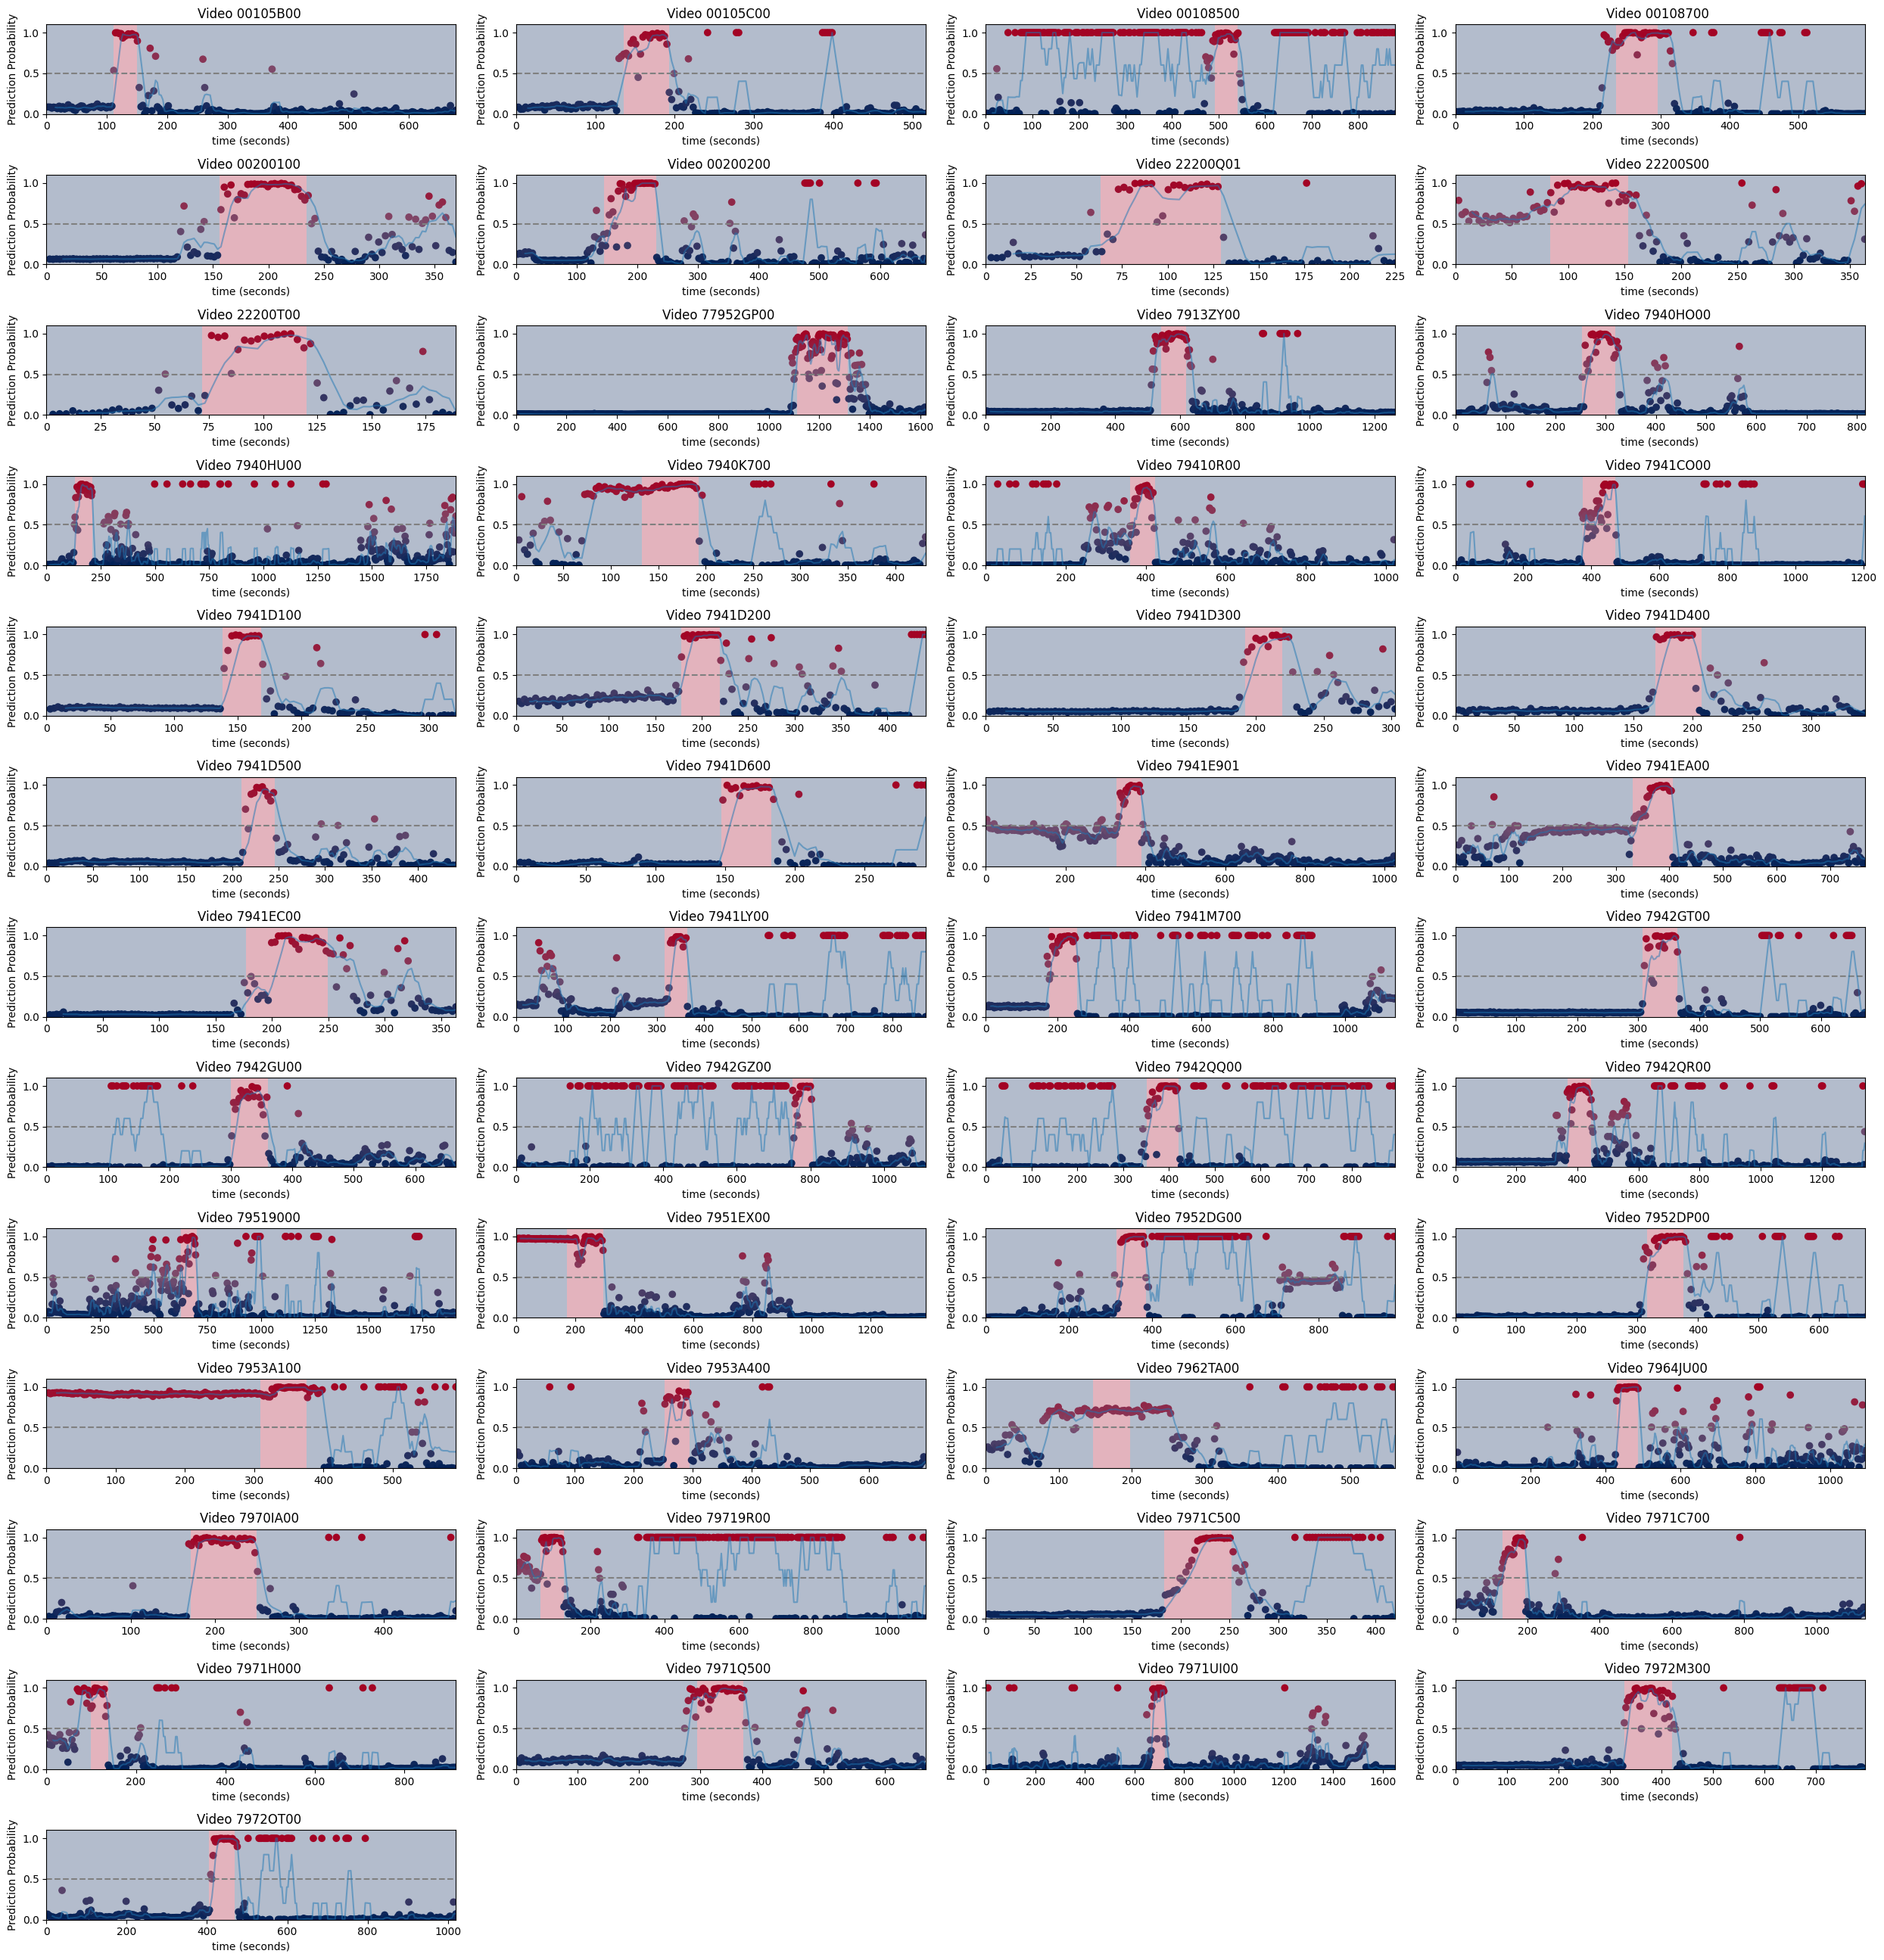

In [12]:
ac_c, vl_c = plot_all_txt_files(os.path.join(os.getcwd(),"Test_results_cropped"))

In [13]:
def plot_all_txt_files_cm(directory_path):
    # Get all .txt files in the directory
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    if not txt_files:
        print("No .txt files found in the directory.")
        return

    # Calculate the grid dimensions
    n_files = len(txt_files)
    n_cols = min(6, n_files * 2)  # Max 6 columns (doubled from 3)
    n_rows = (n_files - 1) // (n_cols // 2) + 1

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 2.5 * n_rows))  # Doubled width from 15 to 30
    gs = GridSpec(n_rows, n_cols, figure=fig, height_ratios=[1]*n_rows, width_ratios=[1]*n_cols)
    accs = []
    video_lengths = []
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i,y[i],y[i])
    
    for i, txt_file in enumerate(txt_files):
        row = i // (n_cols // 2)
        col = (i % (n_cols // 2)) * 2
        
        # Create a subplot spanning two columns
        ax = fig.add_subplot(gs[row, col:col+2])
        title = f"Video {Videos_key[i]} "
        
        # Plot the predictions and labels
        file_path = os.path.join(directory_path, txt_file)
        cm, video_length = plot_predictions_and_labels_ax(file_path, title=title, ax=ax, cm_only=True)
        ax.bar(x=["TN", "TP", "FN", "FP"], height = [cm[0,0], cm[1,1], cm[0,1], cm[1,0]])
        addlabels(["TN", "TP", "FN", "FP"], [cm[0,0], cm[1,1], cm[0,1], cm[1,0]])
        ax.set_title(title)
        acc = (100*(cm[0,0]+cm[1,1])/(sum(sum(cm))))
        accs.append(acc)
        video_lengths.append(video_length)
    print(f"Mean Accuracy: {(np.mean(accs)):.2f}%")
    print(f"Median Accuracy: {(np.median(accs)):.2f}%")

    plt.tight_layout()
    plt.show()

In [17]:
# plot_all_txt_files_cm(os.path.join(os.getcwd(),"Test_results_uncropped"))

In [18]:
# plot_all_txt_files_cm(os.path.join(os.getcwd(),"Test_results_cropped"))

NameError: name 'vl_c' is not defined

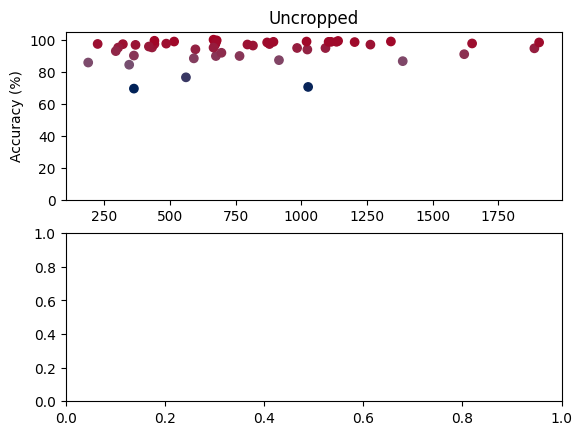

In [15]:
s_color = "#a30324"
ns_color = "#002157"
m_color = "#7a5071"
ac_cmap = LinearSegmentedColormap.from_list("pred_colormap", [ns_color, m_color, s_color])
fig, axs = plt.subplots(2,1)
axs[0].scatter(vl, ac, c=ac, cmap=ac_cmap, vmin=np.min(ac), vmax=np.max(ac), alpha=1)
axs[0].set_ylim([0,105])
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Uncropped")
axs[1].scatter(vl_c, ac_c, c=ac_c, cmap=ac_cmap, vmin=np.min(ac_c), vmax=np.max(ac_c), alpha=1)
axs[1].set_ylim([0,105])
axs[1].set_title("Cropped")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_xlabel("Video Length (seconds)")
plt.tight_layout()
plt.show()

from scipy import stats

r_uncropped, p_uncropped = stats.pearsonr(vl, ac)
r_cropped, p_cropped = stats.pearsonr(vl_c, ac_c)

print(f"Uncropped data - Correlation coefficient: {r_uncropped}, p-value: {p_uncropped}")
print(f"Cropped data - Correlation coefficient: {r_cropped}, p-value: {p_cropped}")

### Correlation between seizure proportion and acc??

In [16]:
import cv2
import re

def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    cap.release()
    
    return frame_count, fps

def process_patient_videos(file_path):
    patient_data = {}
    current_patient = None
    total_frames = 0
    total_seizure = 0
    total_non_seizure = 0

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('Patient'):
                current_patient = line.strip()
                patient_data[current_patient] = {
                    'total_frames': 0,
                    'seizure_frames': 0,
                    'non_seizure_frames': 0,
                    'videos': []
                }
            elif line.startswith('('):
                match = re.match(r"\('(.+\.mp4)', (\d+), (\d+), '(.+)', sec\)", line.strip())
                if match:
                    video_path, start_sec, end_sec, _ = match.groups()
                    start_sec = int(start_sec)
                    end_sec = int(end_sec)
                    
                    frame_count, fps = get_video_info(video_path)
                    if frame_count and fps:
                        seizure_frames = (end_sec - start_sec) * fps
                        non_seizure_frames = frame_count - seizure_frames
                        
                        total_frames += frame_count
                        total_non_seizure += non_seizure_frames
                        total_seizure += seizure_frames

                        patient_data[current_patient]['total_frames'] += frame_count
                        patient_data[current_patient]['seizure_frames'] += seizure_frames
                        patient_data[current_patient]['non_seizure_frames'] += non_seizure_frames
                        
                        patient_data[current_patient]['videos'].append({
                            'video_path': video_path,
                            'total_frames': frame_count,
                            'fps':fps,
                            'seizure_frames': seizure_frames,
                            'non_seizure_frames': non_seizure_frames
                        })
    metadata = {
        'total_frames': total_frames,
        'seizure_frames': total_seizure,
        'nonseizure_frames': total_non_seizure
    }

    return [patient_data, metadata]

In [17]:
patient_data, metadata = process_patient_videos(os.path.join(os.getcwd(), "annotations", "usuable_data.txt"))
video_datadict = []
for patient, data in patient_data.items():
        for video in data['videos']:
            video_datadict.append(
                  {
                        "video": video,
                        "length": video['total_frames'],
                        "seizure_frames": video['seizure_frames'],
                        "non_seizure_frames": video['non_seizure_frames'],
                        "seizure_proportion": video['seizure_frames']/video['total_frames']
                  }
                )

Error opening video file videos/7942GT00.mp4


TypeError: cannot unpack non-iterable NoneType object

### Final bigboy stats

In [60]:
def process_diagnostics_files(directory_path):
    total_confusion_matrix = None
    metrics = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': [],
        'AUC': []
    }
    weights = []
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            with open(os.path.join(directory_path, filename), 'r') as file:
                content = file.read()
                
                # Extract confusion matrix
                confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
                confusion_matrix = confusion_matrix_pattern.search(content)
                if confusion_matrix:
                    cm = np.array([
                        list(map(int, confusion_matrix.group(1).split())),
                        list(map(int, confusion_matrix.group(2).split()))
                    ])
                    if total_confusion_matrix is None:
                        total_confusion_matrix = np.array(cm)
                    else:
                        total_confusion_matrix += np.array(cm)
                    
                    # Calculate weight (total number of predictions)
                    weight = np.sum(cm)
                    weights.append(weight)
                
                # Extract metrics
                for metric in metrics.keys():
                    match = re.search(f'{metric}: ([\d.]+)', content)
                    if match:
                        metrics[metric].append(float(match.group(1)))
    
    # Calculate weighted average metrics
    avg_metrics = {}
    for metric, values in metrics.items():
        if values and len(values) == len(weights):
            result = str(np.round(np.average(values, weights=weights),3)) + " ± " + str(np.round(np.sqrt(np.cov(values, aweights=weights)),3))
            avg_metrics[metric] = result
        else:
            avg_metrics[metric] = np.nan
    
    return total_confusion_matrix, avg_metrics

def print_results(confusion_matrix, metrics):
    print("Sum of Confusion Matrices:")
    print(np.array2string(confusion_matrix, separator=', '))
    print("\nAverage Metrics:")
    for metric, value in metrics.items():
        print(f"{metric:<20} {value}")

In [62]:
cm_uc, metrics_uc = process_diagnostics_files(os.path.join(os.getcwd(),"TEST_LOPO/LOPO_TEST_allvids"))
print("\n---Uncropped Results---")
print_results(flip_matrix_entries(cm_uc), metrics_uc)


---Uncropped Results---
Sum of Confusion Matrices:
[[11494,   710],
 [   28,  1038]]

Average Metrics:
Precision            0.67 ± 0.209
Recall               0.973 ± 0.054
F1 Score             0.771 ± 0.16
Accuracy             0.944 ± 0.064
AUC                  0.991 ± 0.015


### Find total unique clips in 4-fold CV

In [155]:
def count_unique_lines(directory_path):
    unique_lines = set()

    def process_file(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                unique_lines.add(line.strip())

    def traverse_directory(path):
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)
                    process_file(file_path)

    traverse_directory(directory_path)
    return len(unique_lines)

count_unique_lines(os.path.join(os.getcwd(), "annotations", "patients"))

13270

In [156]:
4795/13270

0.3613413715146948